# CAT vs DOGS


In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
!unzip /tmp/cats_and_dogs_filtered.zip 

--2021-04-12 06:13:20--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.8.16, 172.217.13.240, 172.217.164.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.8.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   218MB/s    in 0.3s    

2021-04-12 06:13:20 (218 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Archive:  /tmp/cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation

In [3]:
import os
from tqdm import tqdm
import cv2
import numpy as np


def preprocess():
    data_type=["train","validation"]
    labels=['cats','dogs']
    code={'cats':0,'dogs':1}
    training_data=[]
    validation_data=[]

    for d_type in data_type:
        cats=0
        dogs=0
        data=[]
        for label in labels:
            print(label)
            path=os.path.join("cats_and_dogs_filtered/"+d_type,label)
            for pic in tqdm(os.listdir(path)):
                dir=os.path.join(path,pic)
                # try:
                img=cv2.imread(dir,cv2.IMREAD_GRAYSCALE)
                # shape=np.min([shape,np.min(len(img))])
                # print(shape)
                img=cv2.resize(img,(150,150))
                img=img/255 
                data.append([np.array(img),np.eye(2)[code[label]]])
                if (label=="cats"):
                    cats=cats+1
                else:
                    dogs=dogs+1
        if d_type=="train":
            training_data=data
        else:
            validation_data=data

        print("\n",d_type,"set has:")
        print(cats,"Cat images")
        print(dogs,"Dog images")
    
    

    return training_data,validation_data


In [4]:
train_data,validation_data=preprocess()

  6%|▋         | 65/1000 [00:00<00:01, 649.66it/s]

cats


  8%|▊         | 75/1000 [00:00<00:01, 740.79it/s]

dogs


 18%|█▊        | 89/500 [00:00<00:00, 879.30it/s]


 train set has:
1000 Cat images
1000 Dog images
cats


 16%|█▋        | 82/500 [00:00<00:00, 813.72it/s]

dogs


100%|██████████| 500/500 [00:00<00:00, 814.66it/s]


 validation set has:
500 Cat images
500 Dog images


In [5]:
import tensorflow.keras as keras

class Model():
  def __init__(self,input_shape=(150,150,1), num_classes=2):
    self.model=keras.Sequential()
    self.model.add(keras.layers.Input(shape=(input_shape)))
    self.model.add(keras.layers.Conv2D(32, 3, activation='relu'))
    self.model.add(keras.layers.MaxPool2D(2))
    self.model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    self.model.add(keras.layers.MaxPool2D(2))
    self.model.add(keras.layers.Conv2D(128, 3, activation='relu'))
    self.model.add(keras.layers.MaxPool2D(2))
    self.model.add(keras.layers.Conv2D(256, 3, activation='relu'))
    self.model.add(keras.layers.MaxPool2D(2))
    self.model.add(keras.layers.Flatten())
    self.model.add(keras.layers.Dense(126))
    self.model.add(keras.layers.Dense(2,activation="softmax"))

  def summary(self):
    self.model.build()
    self.model.summary()

  def train(self,train,val):
    train_X=np.array([i[0] for i in train])
    train_X=np.reshape(train_X,(-1,150,150,1))

    train_Y=np.array([i[1] for i in train])

    val_X=np.array([i[0] for i in val])
    val_X=np.reshape(val_X,(-1,150,150,1))

    val_Y=np.array([i[1] for i in val])
    self.model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=['acc'])

    self.model.fit(train_X,train_Y,validation_data=(val_X,val_Y),epochs=20)

  def predict(self,data):
    data=np.array(data)
    data=np.reshape(data,(-1,150,150,1))
    return self.model.predict(data)


In [6]:
nn=Model()
nn.summary()
nn.train(train_data,validation_data)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

[[0.00142398 0.99857605]]
prediction:  dog
correct answer:  cat


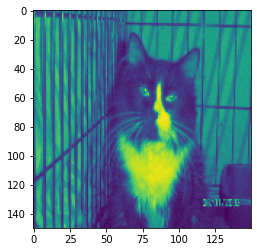

In [10]:
import matplotlib.pyplot as plt
label=["cat","dog"]
data_point=362
plt.imshow(validation_data[data_point][0])
output=nn.predict(validation_data[data_point][0])
print(output)
print("prediction: ",label[np.argmax(output)])
print("correct answer: ",label[np.argmax(validation_data[data_point][1])])


In [8]:
np.argmax([0.33,0.6])

1

prediction : dog
actual : dog


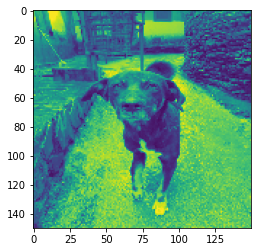

In [21]:
img=cv2.imread("kutta2.jpg",cv2.IMREAD_GRAYSCALE)
img=cv2.resize(img,(150,150))
img=img/255

print("prediction :",label[np.argmax(nn.predict(img))])
print("actual : dog")
plt.imshow(img)
